# Particle Tracking Code - Demonstration using silica beads imaged under bright-field

We'll use the *widely* used particle tracking code that's based on code developed by [John Crocker](http://crocker.seas.upenn.edu/). Originally, that code was developed in IDL. But others have rewritten it in Matlab (for example, [here](http://site.physics.georgetown.edu/matlab/)) and in Python. We'll use the Python code which is provided by [Maria Kilfoil](http://people.umass.edu/kilfoil/). 

The Python particle tracking code we'll use was grabbed from [here](http://people.umass.edu/kilfoil/tools.php). But I've made some slight changes (necessary for how we'll load the images and given the updated version of Python we're using). 

First thing you'll need is a video of particles diffusing. Use the ~0.7 micron silica spheres. Below is an image from a video I took. 
![Image of beads](Silica700_2018-05-16.png)

Notice a couple things. Firstly, there may be a lot of dust and dirt on the optics that is giving us a nasty background. This isn't really the case here but that's because I've selected a small ROI (region-of-interest). Secondly, the particles appear **dark against a lighter background**. For this particle-tracking code, we'll need particles that appear brighter than the background. This is easily acheived with fluorescence imaging. For bright-field imaging this is not always the case (as we see here). When taking images on the microscope, pay attention to the kind of contrast in the image (bright particles on dark background or vice versa) when the focus is varied. An option you can use if your images show dark particles on a bright background is to invert the images using ImageJ. 

To deal with the first issue mentioned above (the nasty background) we'll first calculate the *median* of the image. This is done with [**ImageJ**](https://fiji.sc/). Go to Image -> Stacks -> Z-Project and in "Projection Type" select Median. Now, subtract that median from the other images using Process -> Image Calculator. Check the 32-bit result box. Then convert to 8-bit (Image -> Type) and save as a tiff file. You may elect to crop the image as well. If you need to invert the image in order to see bright beads on a dark background, then, in ImageJ, go Edit -> Invert. See the result of those operations here: ![Background-subtracted image](Silica700_2018-05-16_bgsub.png). 

In [1]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

#For making interactive user interfaces (buttons and sliders and such)
#import ipywidgets as widgets

#Loading the particle tracking software
import sys
sys.path.append("..\\track") #Locate code
import mpretrack #The file mpretrack.py and trackmem.py should be in the location above
import trackmem
import bpass
import tiff_file #Ignore any warnings importing this may cause

from scipy import interpolate

from pyGrad2Surf.g2s import g2s  ##see: https://gitlab.com/chjordan/pyGrad2Surf

from mpl_toolkits.mplot3d import Axes3D

..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


#### You may need to edit the location of the data in the cell below

In [2]:
#Now let's locate the data
#data_directory = "Z:\\Shane_Spring2019\\2019-04-13_neweinkscreen\\" #Notice the double slashes!
data_directory = 'Z:\\Shane_Spring2019\\2019-04-15\\'
data_file = "Stack_ref.tif"

### Let's inspect the data

We'll show the first frame of the movie we'll use. 
Then we'll show what that frame looks like when we filter it using a bandpass filter.

Note that the first line in the cell below is <code>%matplotlib inline</code>. 
This produced figures that show up in this document. But if want separate windows to pop-up that show the figure, then you can use <code>%matplotlib qt5</code>. If you do that, you should create a new code cell above and just run that command. 

<IPython.core.display.Javascript object>


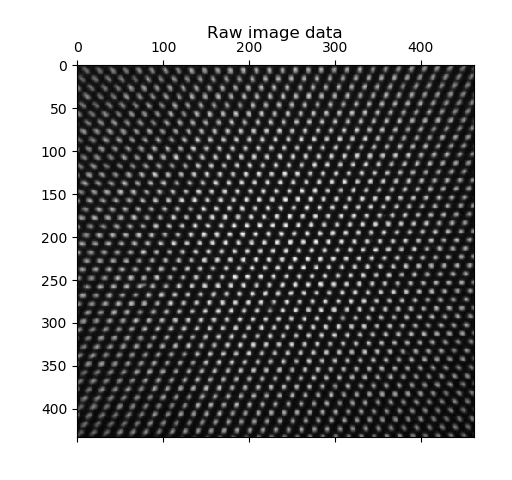

<IPython.core.display.Javascript object>


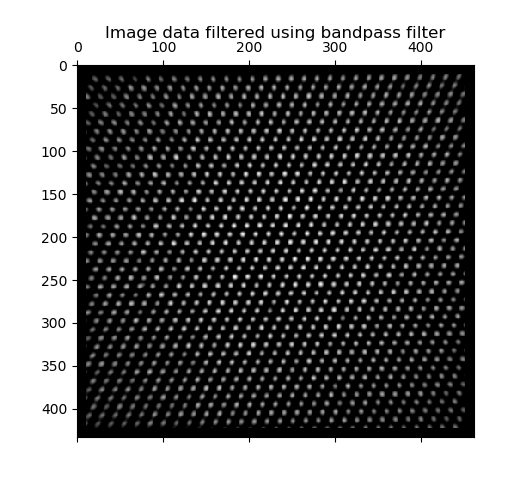

<IPython.core.display.Javascript object>


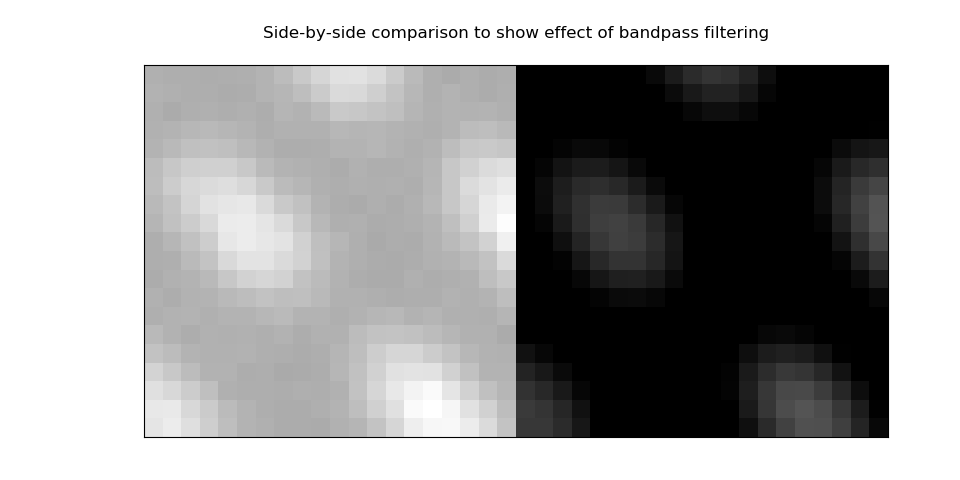

In [3]:
#We use the "tiff_file" module to deal with image data in tif formats.
#The function 'imread' reads in the image. We can either read in the whole entire
#  movie or just read in a specific frame. Here, we are reading in only the first 
#  frame. We do this by setting the optional paratmer 'key' equal to 0. 
frame1_image = tiff_file.imread(data_directory+data_file,key=0)

plt.matshow(frame1_image, cmap=matplotlib.cm.gray) #'cmap' is the colormap used
plt.title("Raw image data")

#Let's try filtering the data with a bandpass filter. This filter is used when
#  identifying features in the image. 
bpass_image = bpass.bpass(frame1_image,1,11)

plt.matshow(bpass_image, cmap=matplotlib.cm.gray)
plt.title("Image data filtered using bandpass filter")

#We'll show a side-by-side comparison of non-filtered and filtered images.
# Using the numpy function 'hstack' to combine two arrays horizontally
plt.matshow(np.hstack((frame1_image[18:38,42:62], bpass_image[18:38,42:62])), cmap=matplotlib.cm.gray, interpolation='nearest')
plt.xticks([]); plt.yticks([]) #This removes the labeling of the axes values
plt.title('Side-by-side comparison to show effect of bandpass filtering');

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


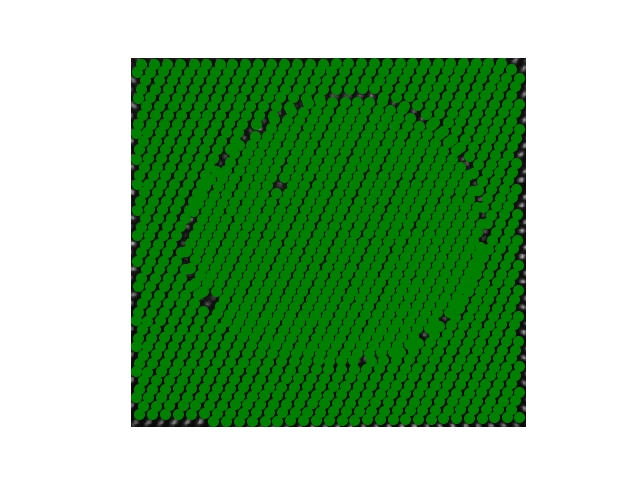


-----------TEST-----------
1344 features found.
Intensity of 1st particle: 154723.73
Rg of 1st particle: 3.92
Eccentricity of 1st particle: 0.0778
[[2.39393325e+02 6.36556613e+00 1.54723728e+05 3.91809901e+00
  7.78403648e-02]
 [2.54277719e+02 6.13709951e+00 1.53666035e+05 3.77446058e+00
  1.69999818e-01]
 [2.69424719e+02 6.22135939e+00 1.35446821e+05 3.68524842e+00
  1.08854174e-01]
 ...
 [9.60606744e+01 4.25546191e+02 1.34427648e+05 4.26184330e+00
  1.25890226e-01]
 [1.11189793e+02 4.25480879e+02 1.57432939e+05 4.51261206e+00
  1.35175975e-01]
 [1.26232750e+02 4.25294193e+02 1.71561254e+05 4.71632788e+00
  1.04586728e-01]]
1344 features kept.
Minimum Intensity : 39824.342290887544
Maximum Rg : 9.80298728820116
Maximum Eccentricity : 0.5032630897503162
--------------------------


In [5]:
#Use the function 'test' in mpretrack to find good set of parameters

###############################################################################
# Options from mpretrack:
#    barI: minimum integrated intensity
#    barRg: maximum radius of gyration squared (in pixel squared)
#    barCc: minimum eccentricity accepted
#    IdivRg: minimum ratio of of integrated intensity to radius of gyr sqrd
#    Imin: minimum intensity of local max -- set to 0 to use default "top 30%"
#    masscut: threshold for integrated intesnity of features before refinement
#    field: 2 for full frame (0 or 1 if interlaced video)
###############################################################################

frame_num = 1 #We'll use the first frame
feature_size =5
plt.figure()
mt, mrej = mpretrack.test(data_directory,data_file,frame_num,feature_size,
                          masscut = 10000, Imin=5000, barI = 10, barRg = 80,
                          barCc = 0.9, IdivRg=0.9, verbose=True, bandpass='bp');

Did that look okay? You should see a figure appear with green dots where the program found particles. Red dots indicate that particles were identified but then discarded due to not meeting the thresholds (like being below the minimum integrated intensity or exceeding the maximum radius of gyration).

Now we'll run the feature-finding algorithm with the paramters we found on *all* frames.

What's in <code>new_tracks</code>?
+ <code>tracks[:,0]</code> is the *x*-coordinate of particle (in terms of pixel) in first frame
+ <code>tracks[:,1]</code> is the *y*-coordinate
+ <code>tracks[:,2]</code> is the integrated brightness of found features
+ <code>tracks[:,3]</code> is the square of the radius of gyration
+ <code>tracks[:,4]</code> is the eccentricity (zero for circularly symmetric features)
+ <code>tracks[:,5]</code> is the frame number
+ <code>tracks[:,6]</code> is the time
+ <code>tracks[:,7]</code> is the trajectory ID number
+ <code>tracks[:,8]</code> is the displacement between frames 1 and 2
+ <code>tracks[:,9]</code> is the x-displacement
+ <code>tracks[:,10]</code> is the y-displacement
+ <code>tracks[:,11]</code> is the *change* in the radius of gyration

In [27]:
num_frames = 2 #number of frames to find particles

recs = np.zeros((82,426,456))
for j,f in enumerate(np.arange(1,83)):
    frame_2 = f
    ims = tiff_file.imread(data_directory+data_file,key=[0,frame_2])

    #Same parameters used as in "test".
    #NOTE: I set verbose=False here so it doesn't print out too much 
    #But you should set verbose=True. 
    #It will then print out how many particles found in each frame.
    '''
    mt = mpretrack.run(data_directory,data_file,num_frames,feature_size,
                       masscut = 10000, Imin=5000, barI = 10, barRg = 80,
                       barCc = 0.9, IdivRg=0.9, verbose=False, bandpass='bp')
    '''

    mt = mpretrack.run_v2(ims,feature_size,
                       masscut = 10000, Imin=5000, barI = 10, barRg = 80,
                       barCc = 0.9, IdivRg=0.9, bandpass='bp', verbose=False)

    # index 7 will be track id
    # index 8 will be displacement
    #index 9 will be x-disp
    #index 10 will be y-disp
    #index 11 will be the change in r_g

    w = np.where(mt[:,5]==0)[0] #Finding dots where in the first frame
    num_dots_in_first_frame = w.max() + 1 #The number of dots found in the first frame
    #print "num in first frame: ", num_dots_in_first_frame

    mtnew = np.zeros((mt.shape[0],mt.shape[1]+6))
    mtnew[:,:7] = mt.copy()
    for i in range(num_dots_in_first_frame):
        disp = np.power(mt[i,0]-mt[:,0],2) + np.power(mt[i,1]-mt[:,1],2)
        sort_disp = np.argsort(disp) #the first arg will be the same dot; second one will be from next frame
        the_disp = disp[sort_disp[1]]
        if (mtnew[i,7] == 0) and (mtnew[sort_disp[1],5]==1) and (the_disp < 40):
            #above if statement checks that the dot hasn't been assigned an ID yet and that it's associated
            # dot is indeed in the next frame
            if (mtnew[sort_disp[1],7]!=0 and the_disp<mtnew[sort_disp[1],8]) or (mtnew[sort_disp[1],7]==0):
                mtnew[i,7] = i
                mtnew[sort_disp[1],7] = i
                xdisp = mt[i,0]-mt[sort_disp[1],0]
                ydisp = mt[i,1]-mt[sort_disp[1],1]
                mtnew[i,8] = disp[sort_disp[1]]
                mtnew[sort_disp[1],8] = disp[sort_disp[1]]
                mtnew[i,9] = xdisp
                mtnew[i,10] = ydisp
                mtnew[i,11] = mt[i,3] - mt[sort_disp[1],3] #change in radius
                mtnew[i,12] = mt[i,4] - mt[sort_disp[1],4] #change in eccentricity

    new_tracks = mtnew[:num_dots_in_first_frame,:].copy()

    w = np.where(new_tracks[:,1]<45)[0]
    #print "Mean x-disp: ", new_tracks[w,9].mean()
    #print "Mean y-disp: ", new_tracks[w,10].mean()
    offset_x = new_tracks[w,9].mean()
    offset_y = new_tracks[w,10].mean()

    #u = interpolate.interp2d(new_tracks[:,0],new_tracks[:,1], -1*new_tracks[:,-2], kind='linear',fill_value=0) 
    #v = interpolate.interp2d(new_tracks[:,0],new_tracks[:,1], new_tracks[:,-1], kind='linear',fill_value=0)

    points = np.transpose(np.vstack((new_tracks[:,0],new_tracks[:,1])))
    u = interpolate.CloughTocher2DInterpolator(points, new_tracks[:,9] - offset_x, fill_value=0)
    v = interpolate.CloughTocher2DInterpolator(points, new_tracks[:,10] - offset_y, fill_value=0)
    x = np.arange(4, 460, 1)
    y = np.arange(4, 430, 1)
    xx,yy = np.meshgrid(x, y)

    reconstructed = g2s(x, y, u((xx,yy)), v((xx,yy)))
    recs[j] = reconstructed.copy() - reconstructed[:20,:].mean()

Frame 0
1290 features kept.
1344 features kept.
Frame 0
1290 features kept.
1346 features kept.
Frame 0
1290 features kept.
1345 features kept.
Frame 0
1290 features kept.
1345 features kept.
Frame 0
1290 features kept.
1343 features kept.
Frame 0
1290 features kept.
1343 features kept.
Frame 0
1290 features kept.
1347 features kept.
Frame 0
1290 features kept.
1343 features kept.
Frame 0
1290 features kept.
1332 features kept.
Frame 0
1290 features kept.
1328 features kept.
Frame 0
1290 features kept.
1328 features kept.
Frame 0
1290 features kept.
1319 features kept.
Frame 0
1290 features kept.
1315 features kept.
Frame 0
1290 features kept.
1313 features kept.
Frame 0
1290 features kept.
1309 features kept.
Frame 0
1290 features kept.
1309 features kept.
Frame 0
1290 features kept.
1306 features kept.
Frame 0
1290 features kept.
1304 features kept.
Frame 0
1290 features kept.
1301 features kept.
Frame 0
1290 features kept.
1295 features kept.
Frame 0
1290 features kept.
1293 feature

<IPython.core.display.Javascript object>


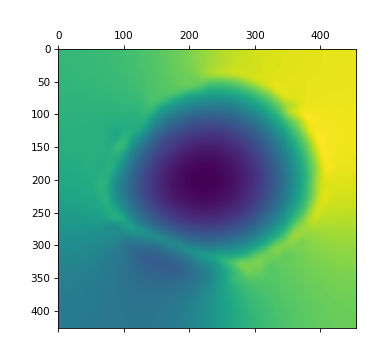

reconstructed shape:  (426L, 456L)


In [28]:
plt.matshow(recs[0] - recs[0,:20,:].mean())
print "reconstructed shape: ", reconstructed.shape

In [29]:
recs2 = recs - recs.min()

In [31]:
recs2 = recs2 * (2**16 - 1)/recs2.max()

In [32]:
tiff_file.imsave('out.tif', recs2.astype(np.uint16))

<IPython.core.display.Javascript object>


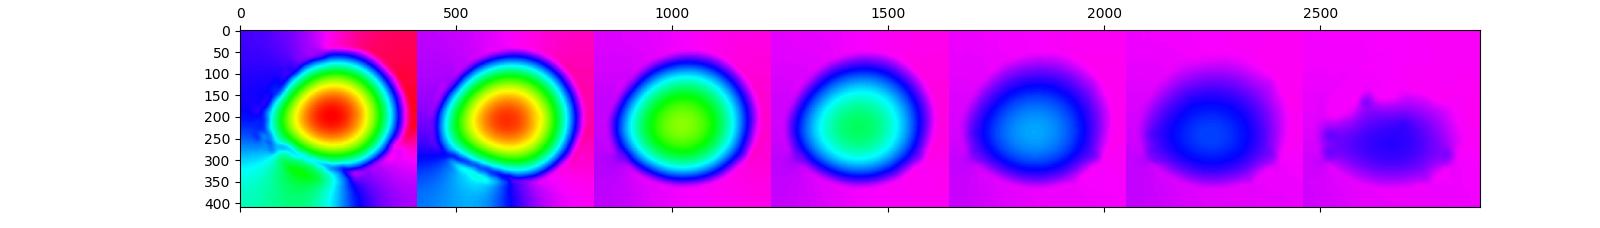

In [241]:
plt.matshow(np.hstack((rec10-rec10[:40,:].mean(),rec20-rec20[:40,:].mean(),
                       rec30-rec30[:40,:].mean(),rec35-rec35[:40,:].mean(),
                       rec40-rec40[:40,:].mean(),rec42-rec42[:40,:].mean(),
                       rec45-rec45[:40,:].mean())), cmap=matplotlib.cm.hsv)

<IPython.core.display.Javascript object>


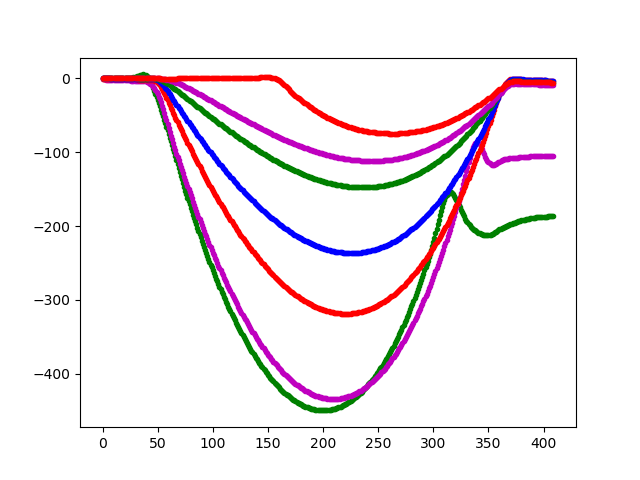

In [242]:
plt.figure()
plt.plot(rec10[:,200]-rec10[:40,:].mean(),'-g.')
plt.plot(rec20[:,200]-rec20[:40,:].mean(),'-m.')
plt.plot(rec30[:,200]-rec30[:40,:].mean(),'-r.')
plt.plot(rec35[:,200]-rec35[:40,:].mean(),'-b.')
plt.plot(rec40[:,200]-rec40[:40,:].mean(),'-g.')
plt.plot(rec42[:,200]-rec42[:40,:].mean(),'-m.')
plt.plot(rec45[:,200]-rec45[:40,:].mean(),'-r.')

<IPython.core.display.Javascript object>


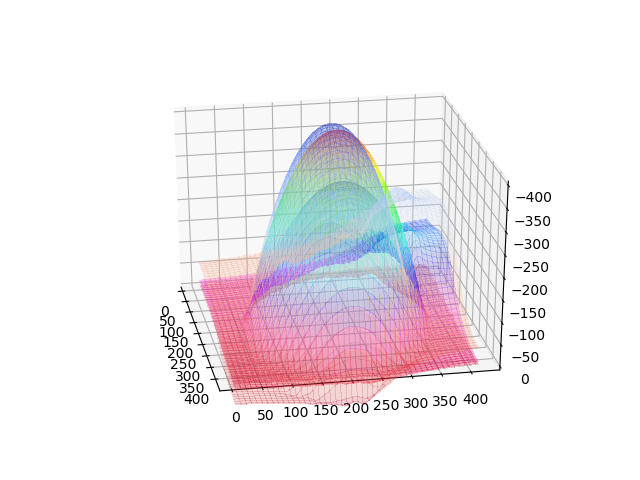

(0, -400)

In [194]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx,yy, rec10-rec10[:40,:].mean(), cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)
surf = ax.plot_surface(xx,yy, rec20-rec20[:40,:].mean(), cmap=matplotlib.cm.hsv,
                       linewidth=0, antialiased=False, alpha=0.2)
surf = ax.plot_surface(xx,yy, rec30-rec30[:40,:].mean(), cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)
ax.set_zlim(0, -400)

<IPython.core.display.Javascript object>


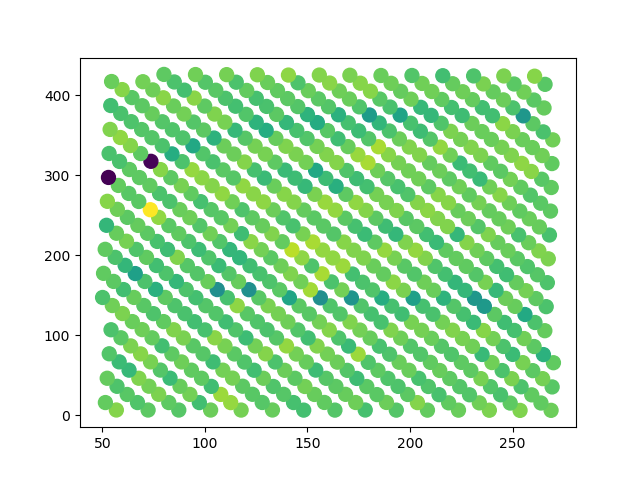

In [120]:
plt.figure()
w = np.where(abs(new_tracks[:,0]-160)<110)[0]
plt.scatter(new_tracks[w,0], new_tracks[w,1], c=new_tracks[w,11],s=100)

<IPython.core.display.Javascript object>


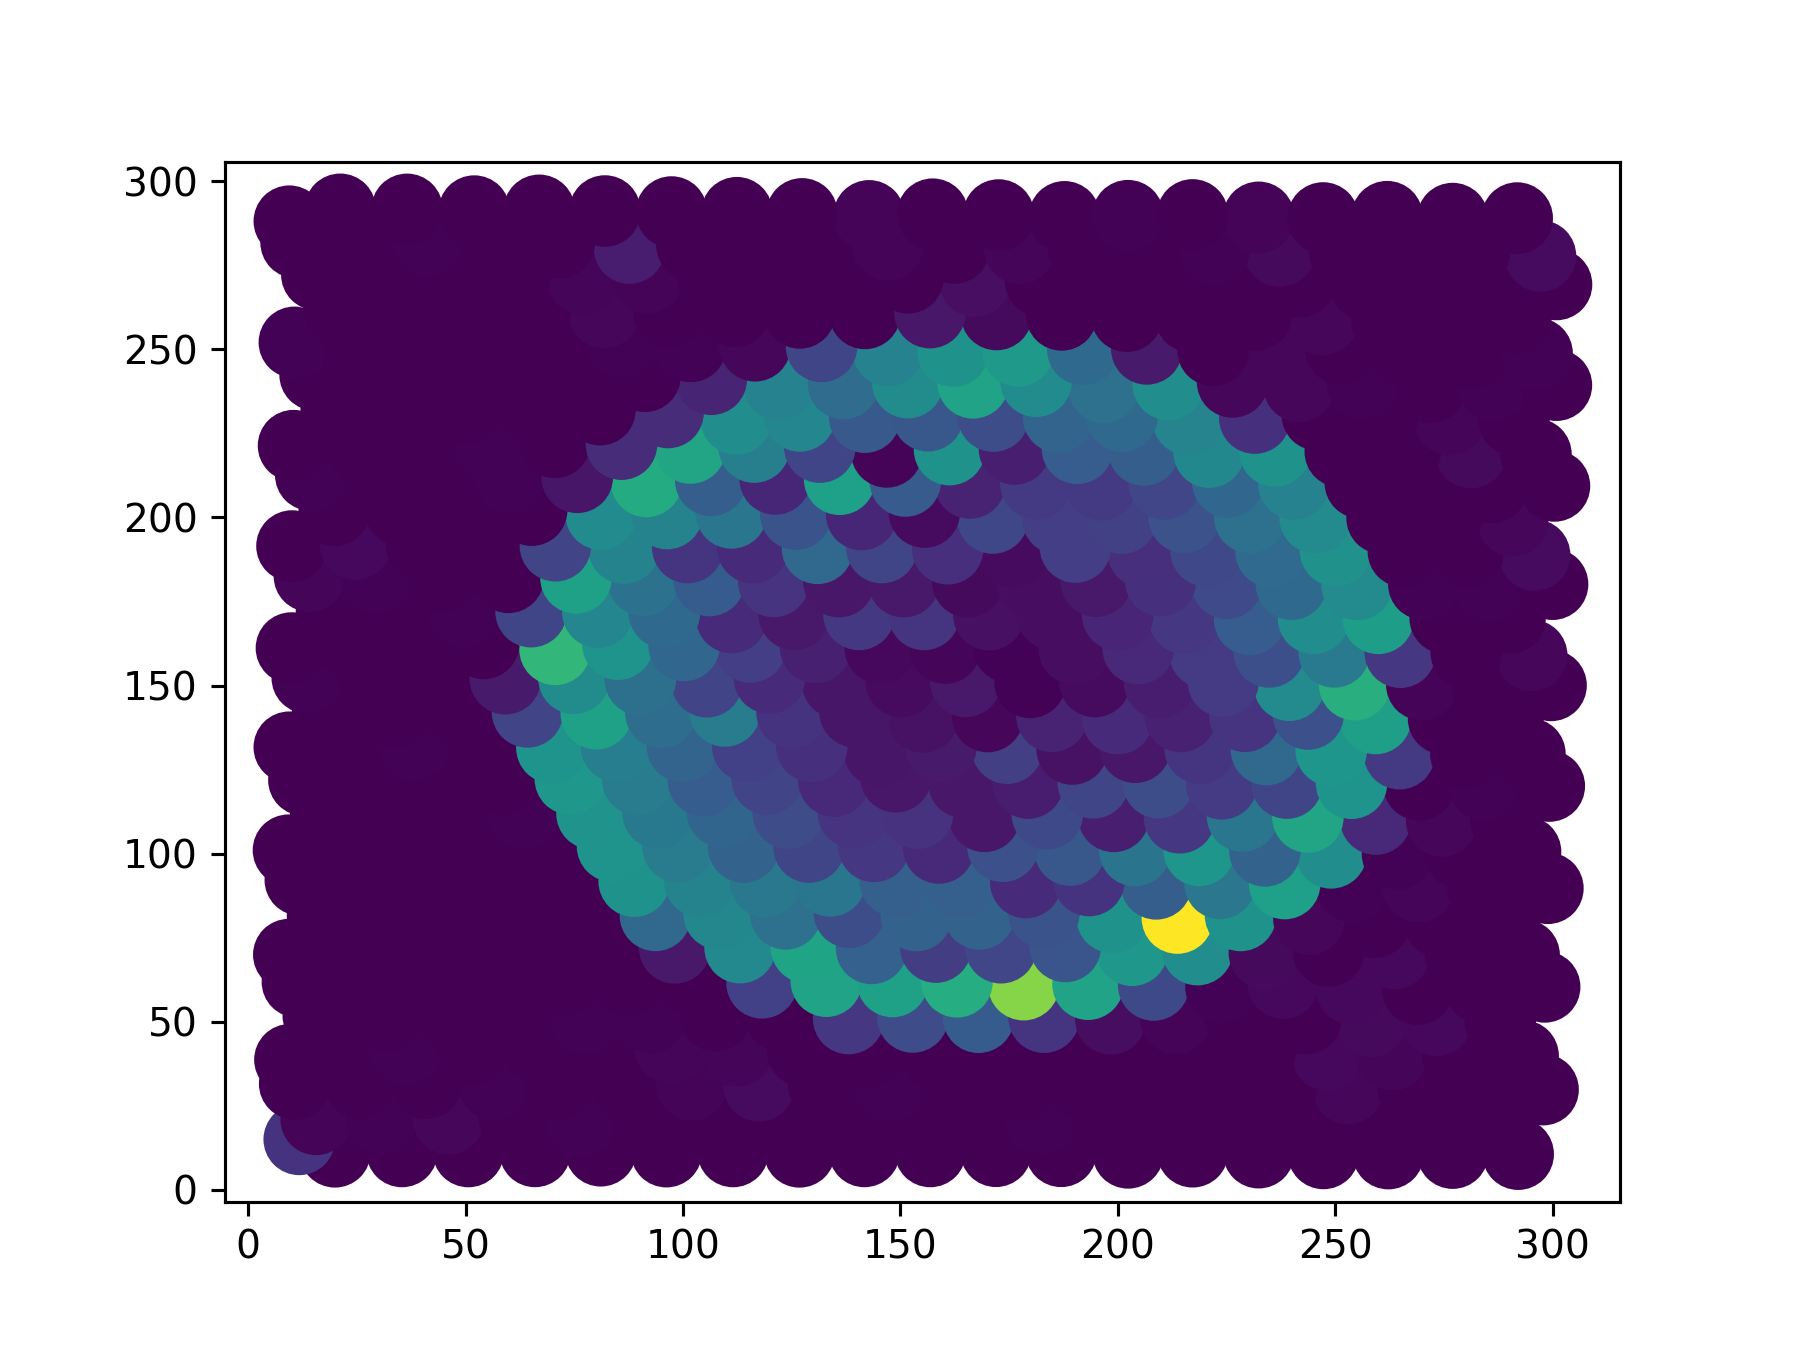

In [73]:
plt.figure()
plt.scatter(new_tracks[:,0], new_tracks[:,1], c=new_tracks[:,8],s=300)

<IPython.core.display.Javascript object>


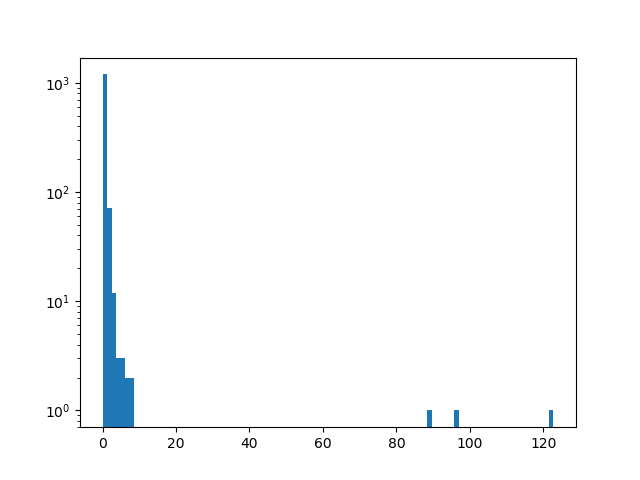

(array([1.194e+03, 7.100e+01, 1.200e+01, 3.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

In [100]:
plt.figure()
plt.hist(new_tracks[:,8],bins=100,log=True)

In [99]:
plt.hist?

In [6]:
# index 7 will be track id
# index 8 will be displacement
#index 9 will be x-disp
#index 10 will be y-disp
#index 11 will be the change in r_g

w = np.where(mt[:,5]==0)[0] #Finding dots where in the first frame
num_dots_in_first_frame = w.max() + 1 #The number of dots found in the first frame
print "num in first frame: ", num_dots_in_first_frame

mtnew = np.zeros((mt.shape[0],mt.shape[1]+6))
mtnew[:,:7] = mt.copy()
for i in range(num_dots_in_first_frame):
    disp = np.power(mt[i,0]-mt[:,0],2) + np.power(mt[i,1]-mt[:,1],2)
    sort_disp = np.argsort(disp) #the first arg will be the same dot; second one will be from next frame
    if (mtnew[i,7] == 0) and (mtnew[sort_disp[1],7]==0) and (mtnew[sort_disp[1],5]==1):
        #above if statement checks that the dot hasn't been assigned an ID yet and that it's associated
        # dot is indeed in the next frame
        mtnew[i,7] = i
        mtnew[sort_disp[1],7] = i
        xdisp = mt[i,0]-mt[sort_disp[1],0]
        ydisp = mt[i,1]-mt[sort_disp[1],1]
        mtnew[i,8] = disp[sort_disp[1]]
        mtnew[sort_disp[1],8] = disp[sort_disp[1]]
        mtnew[i,9] = xdisp
        mtnew[i,10] = ydisp
        mtnew[i,11] = mt[i,3] - mt[sort_disp[1],3] #change in radius
        mtnew[i,12] = mt[i,4] - mt[sort_disp[1],4] #change in eccentricity
        
new_tracks = mtnew[:num_dots_in_first_frame,:].copy()

num in first frame:  1290
